![alt text](https://upload.wikimedia.org/wikipedia/commons/2/22/ENSAE_logo_developpe.jpg)

# Compressed Sensing Project

## [Paper] Graphical Models Concepts in Compressed Sensing - Andrea Montanari et al.

In this paper, the authors present a novel graph-based approach to solving compressed sensing problems. In particular, the - **Approximate Message Passing (AMP)** - algorithm is derived and explain before being compared to the similar but simpler method : the **Iterative Soft Thresholding (IST)**. 

The authors claims that AMP is overall superior to IST, so it is interesting to try and see whether we are able to reproduce the paper's experiment and check to what extent AMP a better alternative to IST.

First of all let's import some modules :

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
import numpy as np
from tqdm import tqdm

from matplotlib import pylab as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 8)

sns.set_style("whitegrid")
sns.set_context("talk")

The experiment's setting is the following :

- sensing matrices with dimensions $m = 2000$, $n = 4000$ and i.i.d. entries uniform in $\{+\frac{1}{\sqrt{m}}, −\frac{1}{\sqrt{m}}\}$.
- original signal $x$ containing $500$ non-zero entries uniform in $\{+1, −1\}$.

The algorithms were run on :

- a number of iterations $t = 10$.
- a total of $40$ instances.

### Parameters

From the experiment's setting we define the following parameters :

In [4]:
m = 2000  # number of observations
n = 4000  # signal size

n_non_zeros = 500  # number of non-zero entries
n_zeros = n - n_non_zeros  # number of zeros in original signal

### Preview of the data

Let's generate a single instance of the data :

**Sensing matrix :**

In [5]:
A = np.random.choice([-1., 1.], p=[0.5, 0.5], size=(m, n))  # random matrix with values in [-1, 1]
A *= 1./np.sqrt(m)  # rescaling the values

# A *= 0.95 / np.linalg.norm(A, ord=2)

print("Sensing matrix shape:", A.shape, '\n')
print("Sensing matrix:", A)

Sensing matrix shape: (2000, 4000) 

Sensing matrix: [[-0.02236068 -0.02236068  0.02236068 ... -0.02236068 -0.02236068
   0.02236068]
 [-0.02236068 -0.02236068 -0.02236068 ...  0.02236068  0.02236068
   0.02236068]
 [ 0.02236068  0.02236068 -0.02236068 ... -0.02236068  0.02236068
  -0.02236068]
 ...
 [ 0.02236068 -0.02236068 -0.02236068 ... -0.02236068  0.02236068
  -0.02236068]
 [ 0.02236068  0.02236068 -0.02236068 ... -0.02236068 -0.02236068
   0.02236068]
 [-0.02236068  0.02236068 -0.02236068 ... -0.02236068 -0.02236068
  -0.02236068]]


**Signal :**

Signal shape: (4000, 1) 



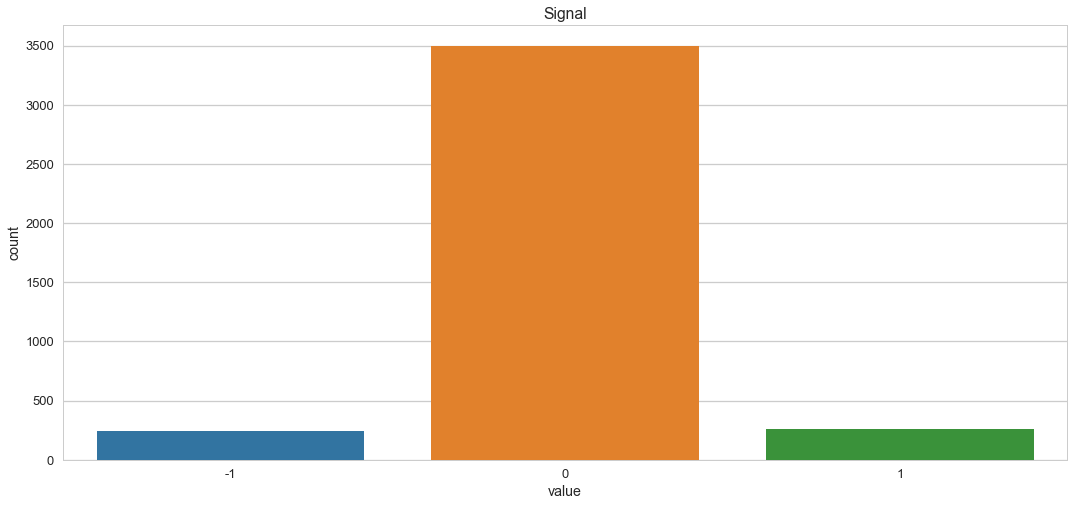

In [6]:
x = np.random.choice([-1, 1], p=[0.5, 0.5], size=(n, 1))  # random vector with values in [-1, 1]

# randomly add the right number of zeros
random_idx = np.random.choice(range(n), size=(n_zeros), replace=False)
x[random_idx] = 0.

print("Signal shape:", x.shape, '\n')

plt.title("Signal")
sns.countplot(x.ravel())
plt.ylabel("count")
plt.xlabel("value")
plt.show()

**Observations :**

Observation shape: (2000, 1) 



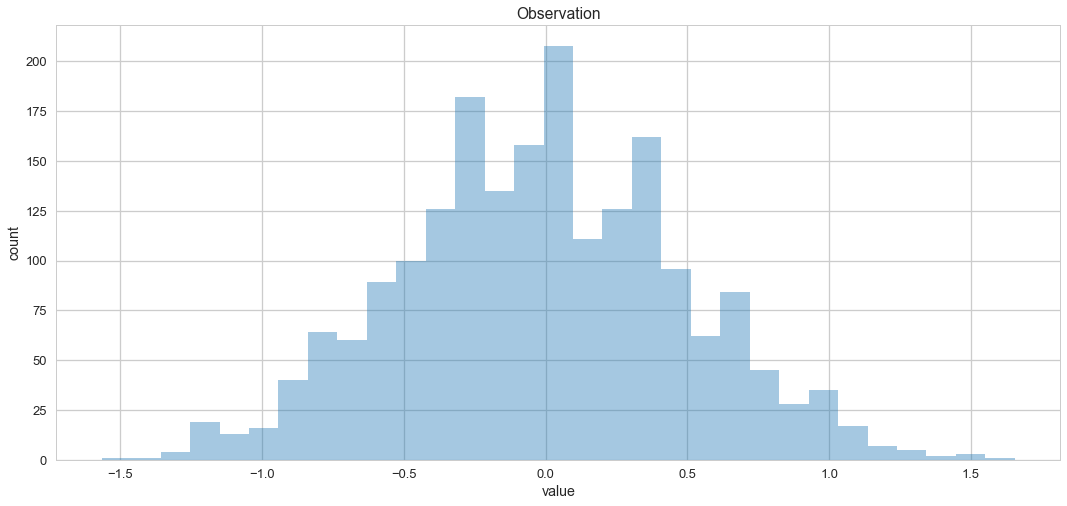

In [7]:
# # Random normal noise with unit variance
# noise = np.random.normal(size=(m, 1))

# Noisy observations
y = np.dot(A, x) # + noise

print("Observation shape:", y.shape, '\n')
plt.title("Observation")
sns.distplot(y.ravel(), kde=False)
plt.ylabel("count")
plt.xlabel("value")
plt.show()

### Implementations

Here we'll define serveral functions we'll use later :
- The `MSE` function to compute the Mean Squared Error of the predictions
- The `soft_thresholding` function to apply soft thresholding with a given threshold
- The `estimate_signal_using_IST` and `estimate_signal_using_AMP` functions that do just that given the observation, a hyperparameter alpha and a number of iterations.

#### Mean Squared Error loss

In [8]:
def MSE(x, y):
    return np.mean((x-y)**2)

#### Soft thresholding

In [9]:
def soft_thresholding(y, theta):
    arr = y.copy()
    cond = (np.abs(arr) > theta)
    arr[cond == 0] = 0
    arr[cond == 1] -= np.sign(arr[cond == 1]) * theta
    return arr

Let's quickly test the `soft_thresholing` function :

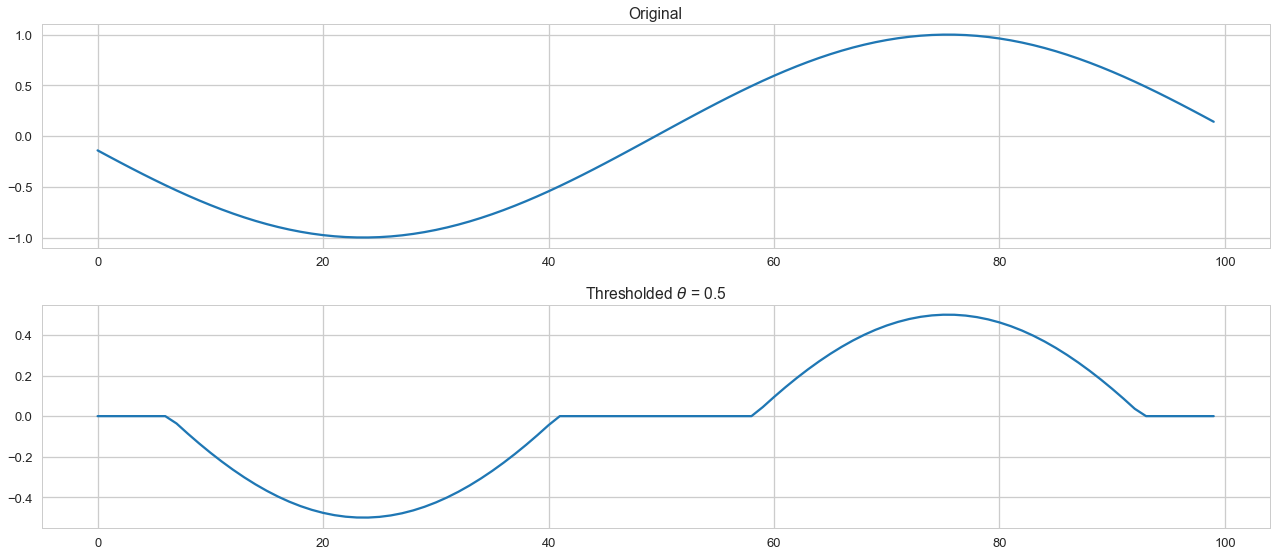

In [10]:
array = np.sin(np.linspace(-3, 3, 100))  # part of the sinus graph

plt.subplot(211)
plt.title("Original")
plt.plot(array)
plt.subplot(212)
plt.title("Thresholded $\\theta$ = 0.5")
plt.plot(soft_thresholding(array, 0.5))
plt.tight_layout()
plt.show()

Seems to work fine.

#### AMP

In [11]:
def estimate_signal_using_AMP(signal, y, A, n_iterations, alpha):
    m, n = A.shape

    # initializing the algorithm
    r = np.zeros(shape=(m, 1))
    x = np.zeros(shape=(n, 1))

    errors = []  # a list to keep track of the MSE

    for _ in range(n_iterations):
        b = sum(x.ravel() != 0)  # 0-pseudo-norm of x
        b /= float(m)  # divided by m

        r = y - np.dot(A, x) + b * r  # update value of r
        x_no_threshold = x + np.dot(A.T, r)  # non thresholded estimation
        
        # compute the threshold for soft thresholding
        theta = np.sqrt((1./m) * (np.linalg.norm(r.ravel(), ord=2) ** 2))
        theta *= alpha
        
        # compute thresholded prediction
        x = soft_thresholding(x_no_threshold, theta)

        # compute the MSE of the prediction
        errors.append(MSE(x, signal))

    return {'x': x , 'x_no_threshold': x_no_threshold, 'errors': errors}

Let's quickly test the method on the data of earlier :

In [12]:
AMP = estimate_signal_using_AMP(x, y, A, n_iterations=100, alpha=1.41)

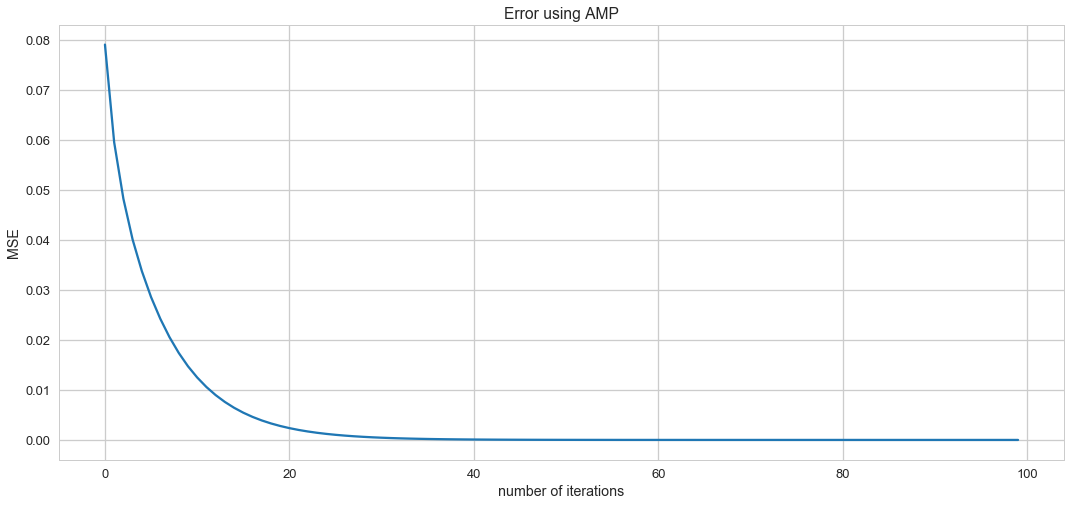

In [13]:
plt.title("Error using AMP")
plt.plot(AMP["errors"])
plt.xlabel('number of iterations')
plt.ylabel('MSE')
plt.show()

Looks alright.

#### IST

In [14]:
def estimate_signal_using_IST(signal, y, A, n_iterations, alpha):
    m, n = A.shape

    # initializing the algorithm
    r = np.zeros(shape=(m, 1))
    x = np.zeros(shape=(n, 1))

    errors = []  # a list to keep track of the MSE

    for _ in range(n_iterations):
        r = y - np.dot(A, x)  # update value of r
        x_no_threshold = x + np.dot(A.T, r)  # non thresholded estimation
        
        # compute the threshold for soft thresholding
        theta = np.sqrt((1./m) * (np.linalg.norm(r.ravel(), ord=2) ** 2))
        theta *= alpha
        
        # compute thresholded prediction
        x = soft_thresholding(x_no_threshold, theta)

        # compute the MSE of the prediction
        errors.append(MSE(x, signal))

    return {'x': x , 'x_no_threshold': x_no_threshold, 'errors': errors}

Let's test this one too :

In [15]:
IST = estimate_signal_using_IST(x, y, A, n_iterations=100, alpha=1.8)

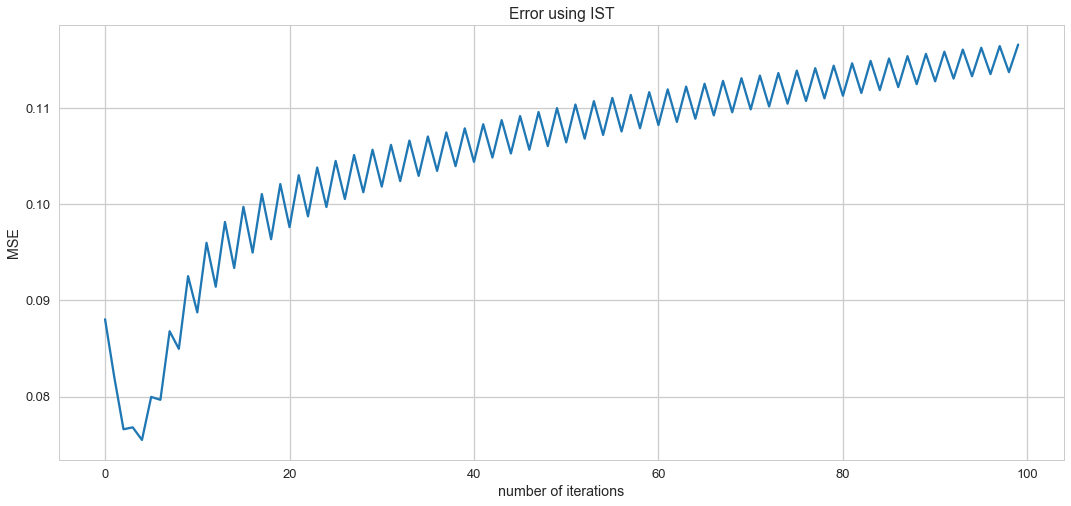

In [16]:
plt.title("Error using IST")
plt.plot(IST["errors"])
plt.xlabel('number of iterations')
plt.ylabel('MSE')
plt.show()

This one doesn't seem to converge ... (we tried many values of alpha but we couldn't get it to work)

### Experiment

Here we will try to reproduce the **Figure.6** of the paper. To do that, we will be generating many instances of sensing matrices and signals then looking at the untresholded prediction's histogram for values of the signal vector equal to 1.

The histogram should be somewhat centered around the true value 1 for both methods, but for AMP it should look like a gaussian whereas for IST it shouldn't.

In [17]:
predictions_AMP = []
predictions_IST = []
for _ in tqdm(range(40)):

    # Same data generation as before
    A = np.random.choice([-1, 1], p=[0.5, 0.5], size=(m, n)) * (1./np.sqrt(m))
    x = np.random.choice([-1, 1], p=[0.5, 0.5], size=(n, 1))
    random_idx = np.random.choice(range(n), size=(n_zeros), replace=False)
    x[random_idx] = 0.
    y = np.dot(A, x)

    # compute predictions after 10 iterations
    IST = estimate_signal_using_IST(x, y, A, n_iterations=10, alpha=1.8)
    AMP = estimate_signal_using_AMP(x, y, A, n_iterations=10, alpha=1.41)    

    # append the predictions to a list
    predictions_AMP = np.append(predictions_AMP, AMP['x_no_threshold'][x==1])
    predictions_IST = np.append(predictions_IST, IST['x_no_threshold'][x==1])

100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


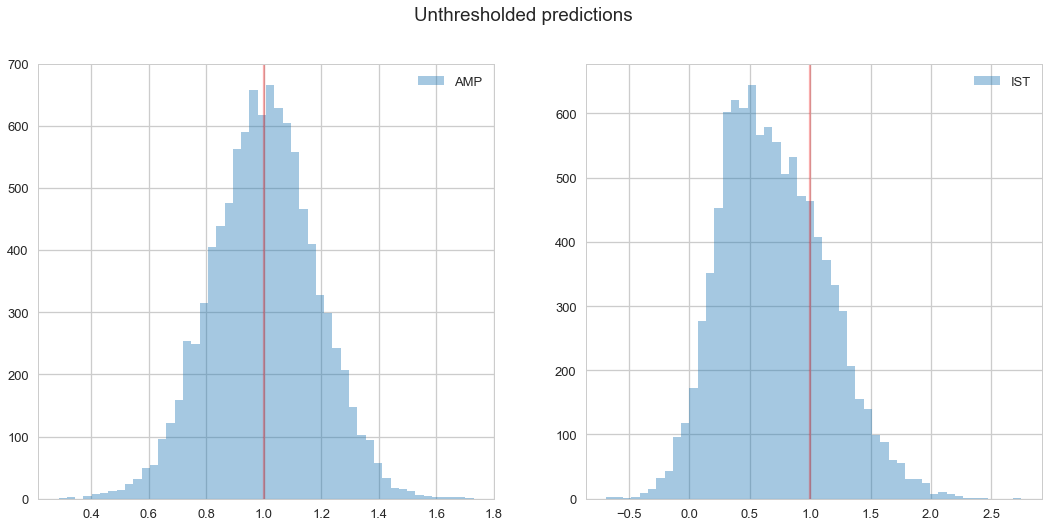

In [18]:
plt.suptitle("Unthresholded predictions")
plt.subplot(121)
plt.axvline(x=1, color='red', alpha=0.3)
sns.distplot(predictions_AMP, label="AMP", kde=False)
plt.legend()
plt.subplot(122)
plt.axvline(x=1, color='red', alpha=0.3)
sns.distplot(predictions_IST, label="IST", kde=False)
plt.legend()
plt.show()

Despite the IST not converging we do get similar distributions. But it is safe to believe that the IST's distribution is biaised toward looking this way for the very reason that the algorithm doesn't converge...

Anyway, the AMP, which is the algorithm of interest here, looks pretty good.